In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


Num GPUs Available: 0


In [ ]:
# Define dataset paths
dataset_path = "dataset"
batch_size = 16
img_size = (224, 224)  # Resize all images

# Data Augmentation Strategy
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  
    validation_split=0.2  # 80% train, 20% validation
)

# Load Training Data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

# Load Validation Data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

print("Class Indices:", train_generator.class_indices)


Found 160 images belonging to 2 classes.


Found 40 images belonging to 2 classes.
Class Indices: {'first_print': 0, 'second_print': 1}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Pretrained MobileNetV2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
base_model.trainable = False

# Added custom layers
x = base_model.output  # extract output from base model
x = GlobalAveragePooling2D()(x)  # pooling to reduce dimensionality
x = Dense(128, activation="relu")(x)  # Fully connected layer
x = Dense(64, activation="relu")(x)  # Another fully connected layer
output_layer = Dense(1, activation="sigmoid")(x)  # Binary classification (real vs fake)


model = Model(inputs=base_model.input, outputs=output_layer)  


model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"]) 

print("Model compiled successfully!")


✅ Model compiled successfully!


In [ ]:
# early stopping to prevent overfitting.
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

print("\n🔹 Training Model (Feature Extraction Stage)...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Train initial layers first
    callbacks=[early_stop]
)



🔹 Training Model (Feature Extraction Stage)...


c:\Users\jaysu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6425 - loss: 0.6247 - val_accuracy: 0.8250 - val_loss: 0.5194
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8208 - loss: 0.5174 - val_accuracy: 0.8250 - val_loss: 0.4573
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8812 - loss: 0.4378 - val_accuracy: 0.9500 - val_loss: 0.3796
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8874 - loss: 0.3649 - val_accuracy: 0.8750 - val_loss: 0.3709
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9237 - loss: 0.2971 - val_accuracy: 0.9500 - val_loss: 0.2579
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8836 - loss: 0.2912 - val_accuracy: 0.9250 - val_loss: 0.2617
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9059 - loss: 0.2697 - val_accuracy: 0.8750 - val_loss: 0.2768
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9837 - loss: 0.1877 - val_accuracy: 0.9500 - val_loss:

In [ ]:
test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False 
)

y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes


Found 200 images belonging to 2 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 898ms/step


In [ ]:
print("\n🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Original", "Counterfeit"]))

print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))



🔹 Classification Report:
              precision    recall  f1-score   support

    Original       0.96      0.94      0.95       100
 Counterfeit       0.94      0.96      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200


🔹 Confusion Matrix:
[[94  6]
 [ 4 96]]


In [ ]:
model.save("qrcode_classifier_tl.h5")
print("Model Saved!")

loaded_model = tf.keras.models.load_model(r"C:\Users\jaysu\Desktop\qr_code_ml\saved_models\qrcode_classifier_tl.h5")
print("Model Loaded Successfully!")


✅ Model Saved!


✅ Model Loaded Successfully!


In [ ]:
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["accuracy"])

print("\n🔹 Fine-Tuning Model...")
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10, 
    callbacks=[early_stop]
)



🔹 Fine-Tuning Model...
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6517 - loss: 0.6154 - val_accuracy: 0.9000 - val_loss: 0.2172
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8252 - loss: 0.4557 - val_accuracy: 0.9250 - val_loss: 0.2526
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9011 - loss: 0.3541 - val_accuracy: 0.9750 - val_loss: 0.1360
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8747 - loss: 0.3389 - val_accuracy: 0.9500 - val_loss: 0.1721
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9010 - loss: 0.2953 - val_accuracy: 0.9250 - val_loss: 0.1680
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9235 - loss: 0.2448 - val_accuracy: 0.9500 - val_loss: 0.1517
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9275 - loss: 0.2103 - val_accuracy: 0.9500 - val_loss: 0.1527
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9707 - loss: 0.1927 - val_accu

In [10]:
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 721ms/step


In [ ]:

print("\n🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Original", "Counterfeit"]))
print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))



🔹 Classification Report:
              precision    recall  f1-score   support

    Original       0.93      0.99      0.96       100
 Counterfeit       0.99      0.92      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200


🔹 Confusion Matrix:
[[99  1]
 [ 8 92]]


In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Original", "Counterfeit"], yticklabels=["Original", "Counterfeit"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


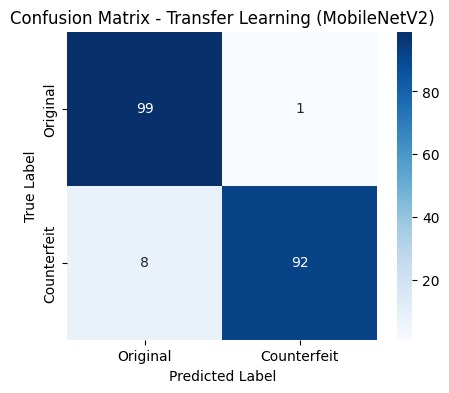

In [13]:
plot_confusion_matrix(y_true, y_pred, "Transfer Learning (MobileNetV2)")
